In [1]:
import torch
import sys
import os
import os.path as osp
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.metrics import precision_recall_curve, recall_score, precision_score, \
balanced_accuracy_score, accuracy_score
from sklearn import metrics
import math
import allel

In [2]:
os.environ['USER_PATH']='/home/users/richras/Ge2Net_Repo'
os.environ['USER_SCRATCH_PATH']="/scratch/users/richras"
os.environ['IN_PATH']='/scratch/groups/cdbustam/richras/data_in'
os.environ['OUT_PATH']='/scratch/groups/cdbustam/richras/data_out'
os.environ['LOG_PATH']='/scratch/groups/cdbustam/richras/logs/'

In [3]:
os.chdir(os.environ.get('USER_PATH'))

In [71]:
%load_ext autoreload
%autoreload 2
from src.utils.dataUtil import load_path, save_file, vcf2npy, get_recomb_rate, interpolate_genetic_pos, form_windows
from src.utils.modelUtil import Params, load_model
from src.utils.labelUtil import nearestNeighbourMapping, repeat_pop_arr
from src.utils.decorators import timer
from src.main.dataset import Haplotype
from src.models import AuxiliaryTask, LSTM, Attention, BasicBlock, Model_A, Model_B, Model_C, BOCD
from src.models.distributions import Multivariate_Gaussian
from src.main.evaluation import eval_cp_batch, reportChangePointMetrics, t_prMetrics, cpMethod, eval_cp_matrix, \
getCpPred
import inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load the model and use valid data 

In [5]:
# Specify the dataset to be evaluated
# chm22 pca full dataset and model

labels_path = osp.join(os.environ['OUT_PATH'],'dogs/labels/data_id_1_umap')
data_path = osp.join(os.environ['OUT_PATH'],'dogs/labels/data_id_1_umap')
models_path=osp.join(os.environ['OUT_PATH'],'dogs/training/Model_B_exp_id_1_data_id_1_umap/') 
dataset_type='valid'

In [6]:
config={}
config['data.labels']=labels_path 
config['data.dir']=data_path 
config['models.dir']=models_path
config['data.dataset_type']=dataset_type
config['cuda']='cuda'
config['model.loadBest']=False
json_path = osp.join(config['models.dir'], 'params.json')
assert osp.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params.rtnOuts=True
params.mc_dropout=False
params.mc_samples=100
params.cp_tol=1
params.balancedLoss=False
_, _, model, _=inference.main(config, params)

 device used: cuda
Loading the datasets...
Finished 'mapping_func' in 0.2930 secs
Finished 'pop_mapping' in 0.1138 secs
Finished 'pop_mapping' in 0.1089 secs
Finished 'transform_data' in 31.5462 secs
Finished '__init__' in 78.2232 secs
Parameter count for model AuxNetwork:37553303
Parameter count for model BiRNN:60355
Parameter count for model logits_Block:2289
Total parameters:37615947
best val loss metrics : {'loss_main': 0.5517209414387235, 'loss_aux': 1.4160133832796997, 'gcd': None, 'mse': 0.5826061695494771, 'smooth_l1': 0.26564804991284524, 'weighted_loss': 0.5517209414387235}
at epoch : 66
train loss metrics: {'loss_main': 0.20956871436848928, 'loss_aux': 1.3196917931910426, 'gcd': None, 'mse': 0.08542019169977416, 'smooth_l1': 0.04027420185643524, 'weighted_loss': 0.2095687129282177}
best val cp metrics : {'loss_cp': 0.6172345509855189, 'prMetrics': OrderedDict([('Precision', array(0.9375)), ('Recall', array(0.00163541)), ('Accuracy', array(0.99017645)), ('A_major', array(0.99

In [72]:
train_dataset = Haplotype("train", params, data_path, labels_path=labels_path)

Finished 'mapping_func' in 0.3134 secs
Finished 'pop_mapping' in 0.1197 secs
Finished 'pop_mapping' in 0.1190 secs
Finished 'transform_data' in 34.4394 secs
Finished '__init__' in 82.4516 secs


In [7]:
#load dataset of admixed population
ref_map_e=pd.read_csv(osp.join(os.environ['OUT_PATH'],'dogs/ref_map_e.tsv'), sep='\t')
ref_map_expt1 = pd.read_csv(osp.join(os.environ['OUT_PATH'],'dogs/ref_map_expt1.tsv'), sep='\t')

In [8]:
ref_map_expt1=ref_map_expt1[ref_map_e.columns]

In [9]:
ref_map_e, ref_map_expt1

(                 Sample         Population Superpopulation code
 0         AfghanHound01       Afghan Hound         Afghan Hound
 1         AfghanHound03       Afghan Hound         Afghan Hound
 2         AfghanHound04       Afghan Hound         Afghan Hound
 3     AiredaleTerrier01   Airedale Terrier     Airedale Terrier
 4     AiredaleTerrier02   Airedale Terrier     Airedale Terrier
 ..                  ...                ...                  ...
 517            PER00758  Yorkshire Terrier    Yorkshire Terrier
 518            PER00777  Yorkshire Terrier    Yorkshire Terrier
 519            PER00816  Yorkshire Terrier    Yorkshire Terrier
 520  YorkshireTerrier01  Yorkshire Terrier    Yorkshire Terrier
 521  YorkshireTerrier02  Yorkshire Terrier    Yorkshire Terrier
 
 [522 rows x 3 columns],
                       Sample                   Population Superpopulation code
 0                 140447_S11             Golden Retriever            Retriever
 1                  149323_S6    

In [590]:
ref_map_expt1[ref_map_expt1.Population=='New Guinea Singing Dog']

,Sample,Population,Superpopulation code
91,NGSD1,New Guinea Singing Dog,East
92,NGSD2,New Guinea Singing Dog,East
93,NGSD3,New Guinea Singing Dog,East
100,NewGuineaSingingDog01,New Guinea Singing Dog,East


In [18]:
ref_map_expt1['Population'].unique

<bound method Series.unique of 0                 Golden Retriever
1               Labrador Retriever
2               Labrador Retriever
3               Labrador Retriever
4                 Golden Retriever
                  ...             
193    West Highland White Terrier
194                        Whippet
195                      Xiasi Dog
196              Yorkshire Terrier
197              Yorkshire Terrier
Name: Population, Length: 198, dtype: object>

In [11]:
only_admixed = ref_map_e[~ref_map_e['Sample'].isin(ref_map_expt1['Sample'])].dropna()

In [12]:
only_admixed

,Sample,Population,Superpopulation code
3,AiredaleTerrier01,Airedale Terrier,Airedale Terrier
4,AiredaleTerrier02,Airedale Terrier,Airedale Terrier
5,AiredaleTerrier05,Airedale Terrier,Airedale Terrier
6,TA001,Airedale Terrier,Airedale Terrier
12,Bern_AlpineDachsbracke,Alpine Dachsbracke,Alpine Dachsbracke
...,...,...,...
439,IndigenousDogVietnam05,Vietnamese Indigenous Dog,Vietnamese Indigenous Dog
440,Vizsla01,Vizsla,Vizsla
441,WE006,Weimaraner,Weimaraner
455,MexicanHairless01,Xoloitzcuintli,Xoloitzcuintli


In [367]:
np.unique(ref_map_expt1['Population'].values)

array(['Afghan Hound', 'Alaskan Husky', 'Alaskan Malamute', 'Basenji',
       'Cairn Terrier', 'Chinese Shar-Pei', 'Chongqing Dog', 'Chow Chow',
       'Golden Retriever', 'Greenland Dog', 'Greyhound',
       'Italian Greyhound', 'Jindo', 'Labrador Retriever',
       'New Guinea Singing Dog', 'Norwich Terrier', 'Saluki',
       'Scottish Deerhound', 'Scottish Terrier', 'Shiba Inu',
       'Siberian Husky', 'Tibetan Mastiff', 'Tibetan Mastiff - China',
       'West Highland White Terrier', 'Whippet', 'Xiasi Dog',
       'Yorkshire Terrier'], dtype=object)

In [366]:
np.unique(only_admixed['Population'].values)

array(['Airedale Terrier', 'Alpine Dachsbracke',
       'American Hairless Terrier', 'Australian Cattle Dog',
       'Australian Terrier',
       'Bavarian Hound (Bayerischer Gebirgsschweisshund)', 'Beagle',
       'Bearded Collie', 'Belgian Malinois', 'Belgian Sheepdog',
       'Belgian Tervuren', 'Berger Blanc Suisse', 'Berger Picard',
       'Bernese Mountain Dog', 'Black Russian Terrier',
       'Black and Tan Coonhound', 'Bloodhound', 'Border Collie',
       'Border Terrier', 'Borzoi', 'Boston Terrier',
       'Bouvier des Flandres', 'Brittany', 'Bull Terrier', 'Bulldog',
       'Bullmastiff', 'Cane Corso', 'Carolina Dog', 'Caucasian Ovcharka',
       'Cavalier King Charles Spaniel', 'Chesapeake Bay Retriever',
       'Chihuahua', 'Chinese Crested', 'Chinese Indigenous Dog',
       'Chinook', 'Clumber Spaniel', 'Cocker Spaniel (American)',
       'Curly-Coated Retriever', 'Dachshund', 'Dalmatian', 'Dingo',
       'Doberman Pinscher', 'East Siberian Laika', 'Elo',
       'English C

In [137]:
only_admixed['Sample'].values

array(['AiredaleTerrier01', 'AiredaleTerrier02', 'AiredaleTerrier05',
       'TA001', 'Bern_AlpineDachsbracke', 'AmericanHairlessTerrier01',
       'AC023', 'AustralianCattleDog01', 'AustralianCattleDog02',
       'AustralianCattleDog03', 'AR001', 'BG064', 'CFA.117995',
       'Beagle01', 'Beagle02', 'Beagle03', 'Beagle04', 'BeardedCollie01',
       'BeardedCollie02', 'BeardedCollie03', 'BeardedCollie04',
       'BeardedCollie05', 'BeardedCollie06', 'BeardedCollie07',
       'BelgianMalinois01', 'BelgianMalinois02', 'BelgianMalinois03',
       'MA0163', 'MA142', 'BelgianSheepdog01', 'BelgianSheepdog02',
       'BelgianSheepdog03', 'BelgianSheepdog04', 'BelgianSheepdog05',
       'BelgianSheepdog06', 'BelgianSheepdog07', 'BelgianTervuren01',
       'BelgianTervuren02', 'BelgianTervuren03', 'BelgianTervuren05',
       'BelgianTervuren06', 'BelgianTervuren07', 'BelgianTervuren08',
       'BelgianTervuren09', 'BelgianTervuren10', 'BelgianTervuren11',
       'BelgianTervuren04', 'BergerBlan

In [14]:
#now from the vcf of expt_e, get chr22_filtered for an admixed sample
vcf=allel.read_vcf(osp.join(os.environ['OUT_PATH'],'dogs/sm_expt1/chr22/chr22_filtered.vcf'))

In [15]:
vcf

{'calldata/GT': array([[[0, 1],
         [0, 1],
         [0, 1],
         ...,
         [0, 1],
         [0, 1],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 0],
         [0, 0],
         [0, 0],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        ...,
 
        [[0, 1],
         [0, 0],
         [0, 1],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[0, 1],
         [0, 0],
         [0, 1],
         ...,
         [0, 0],
         [0, 0],
         [0, 0]],
 
        [[1, 1],
         [1, 1],
         [1, 1],
         ...,
         [1, 1],
         [1, 1],
         [1, 1]]], dtype=int8),
 'samples': array(['140447_S11', '149323_S6', '152721_S5', '160822_S4', '164612_S9',
        '172281_S2', '172384_S14', '172724_S8', '173006_S10', '173486_S3',
        '175885_S12', '87125_S1', '91072_S13', '91317_S7', 'AM007',
        'AfghanH

In [44]:
vcf['variants/POS'].shape

(375825,)

In [45]:
vcf['calldata/GT'].shape

(375825, 198, 2)

In [19]:
vcf_unfiltered=allel.read_vcf(osp.join(os.environ['IN_PATH'],'dogs/chr22/chr22_unfiltered_phased.vcf.gz'))

In [21]:
vcf_unfiltered['calldata/GT'].shape, vcf_unfiltered['variants/POS'].shape

((1870317, 722, 2), (1870317,))

In [30]:
selectedPos=vcf['variants/POS']
selectedidx = np.where(np.isin(vcf_unfiltered['variants/POS'],selectedPos))[0]
selectedidx

array([      1,       3,       6, ..., 1870313, 1870314, 1870316])

In [31]:
selectedidx.shape

(375825,)

In [32]:
vcf_all=vcf_unfiltered['calldata/GT'][selectedidx,...]

In [33]:
vcf_all.shape

(375825, 722, 2)

In [36]:
vcf_all_npy=vcf_all.reshape(-1,vcf_all.shape[1]*vcf_all.shape[2]).T
vcf_all_npy.shape

(1444, 375825)

In [1314]:
sample_name='Pekingese01'
i=np.where(vcf_unfiltered['samples']==sample_name)[0].item()
vcf_sample=torch.tensor(vcf_all_npy[2*i,:params.chmlen].reshape(1,-1)).float().to(params.device)

In [1315]:
vcf_sample.shape

torch.Size([1, 375000])

In [1316]:
params.n_win

375

In [1317]:
model.eval()
with torch.no_grad():
    test_results=model(vcf_sample, mask=torch.ones(1,params.n_win,1).to(params.device))

In [1318]:
test_results

modelOuts(coord_aux=tensor([[[-0.3452, -0.7523, -0.0489],
         [ 0.6795,  0.0160,  1.6661],
         [ 0.2080, -0.3835, -0.0047],
         ...,
         [-0.3457, -0.8473, -0.4329],
         [-0.4578, -0.9979, -0.8906],
         [ 0.0492, -0.0808, -0.9941]]], device='cuda:0'), coord_main=tensor([[[ 0.2455, -1.3233,  1.2389],
         [ 0.0924, -1.5901,  1.2797],
         [ 0.0416, -1.6942,  1.2714],
         ...,
         [-0.3558, -0.7428, -0.8264],
         [-0.3493, -0.7051, -0.8212],
         [-0.3188, -0.6220, -0.7898]]], device='cuda:0'), cp_logits=tensor([[[-0.3445],
         [-0.3445],
         [-0.3444],
         [-0.3441],
         [-0.3441],
         [-0.3441],
         [-0.3442],
         [-0.3442],
         [-0.3441],
         [-0.3440],
         [-0.3440],
         [-0.3438],
         [-0.3438],
         [-0.3440],
         [-0.3439],
         [-0.3441],
         [-0.3440],
         [-0.3438],
         [-0.3433],
         [-0.3422],
         [-0.3423],
         [-0.34

In [1319]:
y_pred = test_results.coord_main.detach().cpu()
n_vec_dim=y_pred.shape[-1]
data_tensor = y_pred
batch_size_cpd = data_tensor.shape[0]
mu_prior = torch.zeros((batch_size_cpd, 1,n_vec_dim))
mean_var=torch.mean(torch.var(data_tensor, dim =1),dim=0).unsqueeze(0)
cov_prior = (mean_var.repeat(batch_size_cpd,1).unsqueeze(1)* torch.eye(n_vec_dim)).reshape(batch_size_cpd,1,n_vec_dim,n_vec_dim)
cov_x = cov_prior
likelihood_model = Multivariate_Gaussian(mu_prior, cov_prior, cov_x)
T = params.n_win
model_cpd = BOCD.BOCD(None, T, likelihood_model, batch_size_cpd)
_,_,_,_=model_cpd.run_recursive(data_tensor, 'cpu')

Finished 'run_recursive' in 0.3848 secs


In [1320]:
# granular_pop_dict = load_path(osp.join(labels_path, 'granular_pop.pkl'), en_pickle=True)
# superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)
# pop_sample_map=pd.read_csv(osp.join(labels_path, 'pop_sample_map.tsv'),sep="\t")
# pop_arr=repeat_pop_arr(pop_sample_map)
# cp_target=valid_dataset.data['cps']
# seqlen=cp_target.shape[1]
# rev_pop_dict={v:k for k,v in granular_pop_dict.items()}
# rev_sp_dict={v:k for k,v in superop_dict.items()}

In [1321]:
# index = 2500
# index=2620
# index=51
# index=3000
# index=3100
# index=2445
# index=np.random.choice(idxOfInterest)
# print(index)
# true_cpsSample=cp_target[index,:]
y_predSample=y_pred.squeeze(0)
# y_trueSample=valid_dataset.data['y'][index,:]
# granularpopSample=valid_dataset.data['granular_pop'][index,:]
# namesSample=[rev_pop_dict[i] for i in granularpopSample.astype(int)]
# superPopSample=valid_dataset.data['superpop'][index,:]
# SpNamesSample=[rev_sp_dict[i] for i in superPopSample.astype(int)]

In [1322]:
y_predSample.shape

torch.Size([375, 3])

In [1323]:
pred_cps=getCpPred(cpMethod.gradient.name, y_predSample, 0.1, 1, params.n_win)
pred_cps=pred_cps.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [1324]:
predBOCDSample=model_cpd.cp
pred_cps_BOCD=getCpPred(cpMethod.BOCD.name, predBOCDSample, 5.0, 1, params.n_win)
pred_cps_BOCD=pred_cps_BOCD.squeeze(0).detach().cpu().numpy()# squeeze the batch dimension of 1

In [1325]:
cpIdx=np.nonzero(pred_cps_BOCD)[0]
remWin=3
for i in cpIdx:
    low=max(0,i-remWin)
    high=min(params.n_win, i+remWin)
    pred_cps_BOCD[low:high]=1

In [1326]:
mappedSpArr=nearestNeighbourMapping(labels_path, y_predSample.numpy().reshape(-1,3))

Finished 'nearestNeighbourMapping' in 0.0085 secs


In [1327]:
mappedSpArr.shape

(375,)

In [1328]:
y_True=train_dataset.data['y'].reshape(-1,3)
superpopsTrue=train_dataset.data['superpop'].reshape(-1,)
superop_dict=load_path(osp.join(labels_path, 'superpop.pkl'), en_pickle=True)

In [1329]:
@timer
def plot_unlabeledSample(granularPopSample, y_predSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_True=kwargs.get('y_True')
    superpopsTrue=kwargs.get('superpopsTrue')
    superop_dict=kwargs.get('superop_dict')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    
    fig, ax = plt.subplots(figsize=(12,14))
    plt.rcParams['hatch.color']='grey'
    
    gs1 = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[13,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax1.set_xlim(np.array([-2,2])*.77)
    ax1.set_ylim(np.array([-2,2])*.77)
    ax1.set_zlim(np.array([-2,2])*.77)
    ax2=fig.add_subplot(gs1[1])

    for axis in [ax, ax2]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5)
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_True, superpopsTrue, superop_dict, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colorsPop_sp = sns.color_palette("bright", 10)
#         del colorsPop_sp[1]
#         del colorsPop_sp[4]
#         del colorsPop_sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))

    ax1.add_artist(lgnd)
    colors_pop_dict={granularPopSample[0]:(0/255, 111/255, 84/255)}
    
    alpha=[1]*len(y_predSample)
    if cpShow is None:
        unknownIdx=np.nonzero(pred_cps)[0]
        print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)*100/len(y_predSample)}")
        granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
        colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
        mappedSpArr[unknownIdx]=-1
        colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
        knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
    
    #predictions
    ax1.scatter(y_predSample[knownIdx,0], y_predSample[knownIdx,1], y_predSample[knownIdx,2],\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in knownIdx], alpha)], s=50, zorder=0)
    #changepoints
    ax1.scatter(y_predSample[unknownIdx,0], y_predSample[unknownIdx,1], y_predSample[unknownIdx,2], facecolor='grey', hatch=3*'+',\
    color = [tuple(colors_pop_dict[x])+(y,) for x,y in zip([granularPopNames[i] for i in unknownIdx], alpha)], s=50, zorder=0, marker="D") 
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
    for i, val in enumerate(np.unique(granularPopSample)):
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = val))
    patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=3*'+')) #add UNK legend patch separately
    ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    
    #chm plot of predictions
    ax2.bar(knownIdx, 1.02*np.ones(len(mappedSpArr[knownIdx])), \
            color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], \
            width=1.0)
    ax2.bar(unknownIdx, 1.02*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=3*"+")
    ax2.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=6, labelsize=10)
        ax.set_xlim(0, params.n_win)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
    plt.show()
    plt.close('all')

Finished 'plot_all' in 9.9297 secs
number of changepoints removed:147,39.2


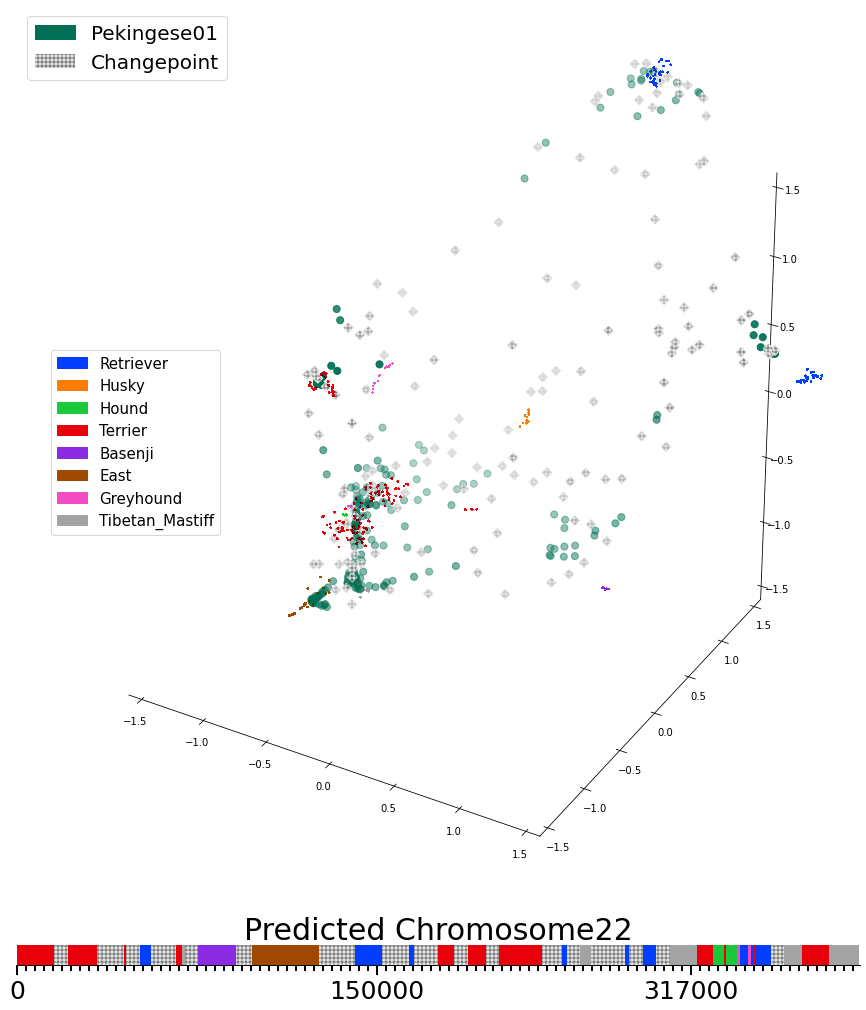

Finished 'plot_unlabeledSample' in 21.8767 secs


In [1330]:
granularPopSample=[sample_name]*params.n_win
plot_unlabeledSample(granularPopSample, y_predSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_True=y_True, superpopsTrue=superpopsTrue, superop_dict=superop_dict)

In [1228]:
@timer
def plot_all(ax, y_True, superpopsTrue, superop_dict, **kwargs):
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')    
    continentaPops=list(superop_dict.values())
    colors_pop = sns.color_palette("bright", 10)
#     del colors_pop[1]
#     del colors_pop[4]
#     del colors_pop[5]
    colors_pop_dict = {k:v for k,v in zip(continentaPops, colors_pop)}
    alpha=[0.03]*len(y_True)
    if cpShow is None:
        alpha=(pred_cps==0).astype(float)
    
    ax.scatter(y_True[:,0], y_True[:,1], y_True[:,2], \
               color = [colors_pop_dict[x]+(y,) for x,y in zip(superpopsTrue, alpha)], marker=".", s=5, zorder=-1) 
    
    patches=[]
   
    for k, val in superop_dict.items():
        patches.append(mpatches.Patch(color = colors_pop_dict[val], label = k))
    lgnd = ax.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.75, 0.12, 1., .5))
    return lgnd, colors_pop_dict


In [647]:
@timer
def plot_unlabeledSample(granularPopSample, y_predSample, **kwargs):
    backgroundAxis=kwargs.get('backgroundAxis')
    y_predCps=kwargs.get('y_predCps')
    y_True=kwargs.get('y_True')
    superpopsTrue=kwargs.get('superpopsTrue')
    superop_dict=kwargs.get('superop_dict')
    cpShow=kwargs.get('cpShow')
    pred_cps=kwargs.get('pred_cps')
    mappedSpArr=kwargs.get('mappedSpArr')
    
    fig, ax = plt.subplots(figsize=(12,14))
    plt.rcParams['hatch.color']='grey'
    
    gs1 = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[13,1])
    ax1=fig.add_subplot(gs1[0],projection='3d')
    ax1.set_xlim(np.array([-2,2])*.77)
    ax1.set_ylim(np.array([-2,2])*.77)
    ax1.set_zlim(np.array([-2,2])*.77)
    ax2=fig.add_subplot(gs1[1])

    for axis in [ax, ax2]:
        axis.set_yticks([])
        axis.spines['top'].set_color('none')
        axis.spines['left'].set_color('none')
        axis.spines['right'].set_color('none')
    ax.set_xticks([])
    fig.subplots_adjust(left=0, right=0.5, bottom=0, top=0.5)
    plt.subplots_adjust(hspace=0.01)
    
    if backgroundAxis:
        lgnd, colorsPop_sp_dict =plot_all(ax1, y_True, superpopsTrue, superop_dict, cpShow=False)
    else:
        continentaPops=list(superop_dict.values())
        colorsPop_sp = sns.color_palette("bright", 10)
#         del colorsPop_sp[1]
#         del colorsPop_sp[4]
#         del colorsPop_sp[5]
        colorsPop_sp_dict = {k:v for k,v in zip(continentaPops, colorsPop_sp)}
        patches=[]
        for k, val in superop_dict.items():
            patches.append(mpatches.Patch(color = colorsPop_sp_dict[val], label = k))
        lgnd = ax1.legend(handles=patches, loc="upper right", fontsize=15, bbox_to_anchor=(-0.15, 0.49, 1., .5))

    ax1.add_artist(lgnd)
    colors_pop_dict=colorsPop_sp_dict
    
    alpha=[1]*len(y_predSample)
    if cpShow is None:
        unknownIdx=np.nonzero(pred_cps)[0]
        print(f"number of changepoints removed:{len(unknownIdx)},{len(unknownIdx)*100/len(y_predSample)}")
        granularPopNames=["UNK" if i in unknownIdx else granularPopSample[i] for i in range(len(granularPopSample))]
        colors_pop_dict["UNK"]=(0.9,0.9,0.9) # grey color
        mappedSpArr[unknownIdx]=-1
        colorsPop_sp_dict[-1]=(0.9,0.9,0.9) # grey color
        knownIdx=[i for i in range(len(granularPopNames)) if granularPopNames[i]!="UNK"]
    
    #predictions
    ax1.scatter(y_predSample[knownIdx,0], y_predSample[knownIdx,1], y_predSample[knownIdx,2],\
    color = [colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], s=50, zorder=0)
    #changepoints
    ax1.scatter(y_predSample[unknownIdx,0], y_predSample[unknownIdx,1], y_predSample[unknownIdx,2], facecolor='grey', hatch=3*'+',\
    color = [colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], s=50, zorder=0, marker="D") 
    
    for axis in [ax1.xaxis, ax1.yaxis, ax1.zaxis]:
        axis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        axis._axinfo["grid"]['color'] = (1,1,1,0)
    patches=[]
#     for i, val in enumerate(np.unique(granularPopSample)):
#         patches.append(mpatches.Patch(color = colors_pop_dict[val], label = val))
#     patches.append(mpatches.Patch(facecolor = (0.9,0.9,0.9), label = "Changepoint", hatch=3*'+')) #add UNK legend patch separately
#     ax1.legend(handles=patches, loc="upper left", fontsize=20)
    
    
    #chm plot of predictions
    ax2.bar(knownIdx, 1.02*np.ones(len(mappedSpArr[knownIdx])), \
            color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[knownIdx],alpha)], \
            width=1.0)
    ax2.bar(unknownIdx, 1.02*np.ones(len(mappedSpArr[unknownIdx])), \
        color=[colorsPop_sp_dict[x]+(y,) for x,y in zip(mappedSpArr[unknownIdx],alpha)], \
        width=1.0, hatch=3*"+")
    ax2.set_title('Predicted Chromosome22', fontsize=30, y=0.3)
    
    for ax in [ax2]:
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(ticker.MultipleLocator(4))
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(which='major', width=2, length=10, labelsize=25)
        ax.tick_params(which='minor', width=2, length=6, labelsize=10)
        ax.set_xlim(0, params.n_win)
        ax.set_ylim(0.99,1.09)
        positions = [0, 160, 300]
        x_labels = [0, 150000, 317000]
        ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter(x_labels))
    
    plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=0.3)
    plt.show()
    plt.close('all')

Finished 'plot_all' in 10.0256 secs
number of changepoints removed:139,37.06666666666667


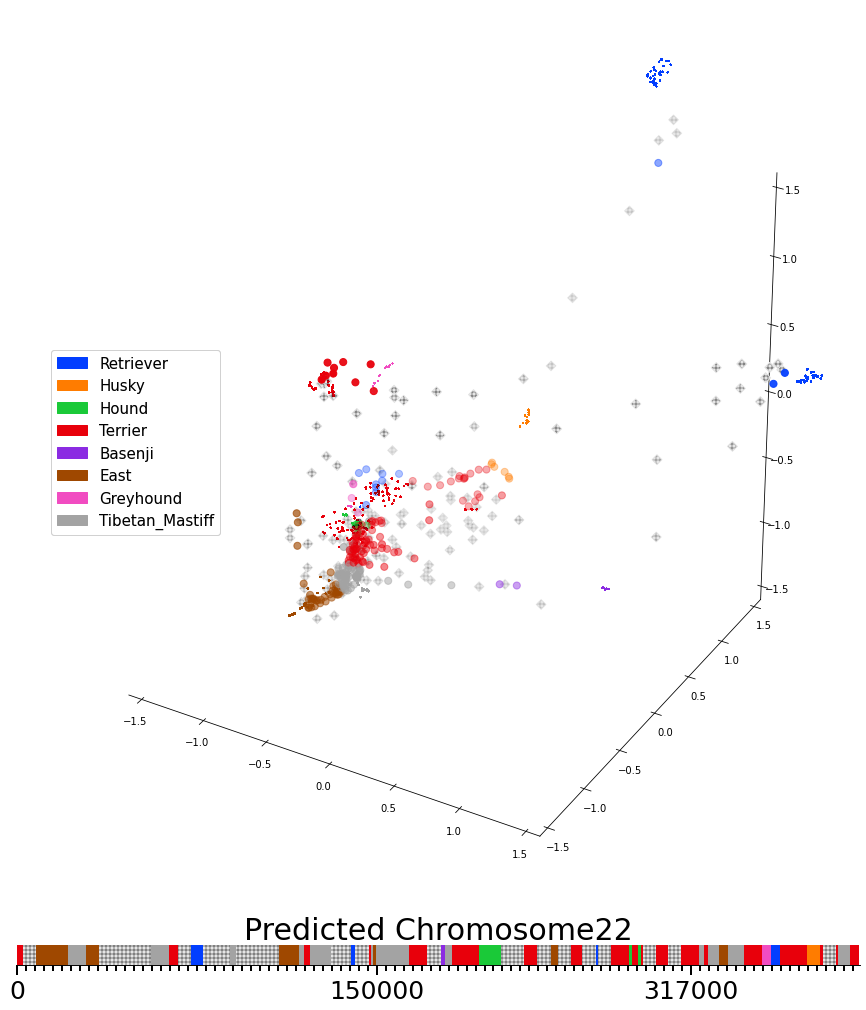

Finished 'plot_unlabeledSample' in 21.9865 secs


In [648]:
granularPopSample=[sample_name]*params.n_win
plot_unlabeledSample(granularPopSample, y_predSample, pred_cps=pred_cps_BOCD, mappedSpArr=mappedSpArr, \
backgroundAxis=True, y_True=y_True, superpopsTrue=superpopsTrue, superop_dict=superop_dict)